# Explore a trained model

This notebook explores some of the things we can plot and analyze with a fully trained model.

Note that this model is coarsely trained - it is not our best effort!

In [17]:
path_to_model = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/trained_models/V15_2016_X_V6/'

# Predictions

In [18]:
import pandas as pd
def load_predictions(path):

    df = pd.read_parquet(path+'predictions.parquet')
    
    
    #Calculate some extra columns
    df['model_predicion_bias'] = df.MODIS_LST - df.predictions
    df['model_predicion_error'] = abs(df.MODIS_LST - df.predictions)
        
    df['ERA_predicion_bias'] = df.MODIS_LST - df.skt_unnormalised
    df['ERA_predicion_error'] = abs(df.MODIS_LST - df.skt_unnormalised)


    print ('----------------------------------MODEL-------------------------------------------------')
    print("Mean/Median/Std prediction bias:", df['model_predicion_bias'].mean(), df['model_predicion_bias'].median(),df['model_predicion_bias'].std())
    print("Mean/Median/Std prediction error:", df['model_predicion_error'].mean(), df['model_predicion_error'].median(),df['model_predicion_error'].std())
    print ('------------------------------------ERA---------------------------------------------------')
    print("Mean/Median/Std prediction bias:", df['ERA_predicion_bias'].mean(), df['ERA_predicion_bias'].median(),df['ERA_predicion_bias'].std())
    print("Mean/Median/Std prediction error:", df['ERA_predicion_error'].mean(), df['ERA_predicion_error'].median(),df['ERA_predicion_error'].std())
    print ('-------------------------------------------------------------------------------------------')

    
    return df

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
import matplotlib.colors as mc
import matplotlib.colorbar as cb 




        
        
        
def global_plot(df,z,projection,vmin,vmax,cmap,absolute_values,logscale,title,markersize,savefig,cbar_label):
    
    
        
       # ccrs.Robinson()
        
    #Setup plotting env
    fig = plt.figure(figsize=[30,20])
    ax = plt.subplot(projection=projection)
    cax = fig.add_axes([0.32, 0.11, 0.4, 0.0125])

    #Get data
    try:
        x = df.longitude
        y = df.latitude
    except: #different sources call lat/lon different things
        x = df.longitude_ERA
        y = df.latitude_ERA

    z1 = df[z]
    if absolute_values:
        z1 = abs(z1)
        if vmin < 0:
            vmin = 0 # dont need negative vmins if plotting absolute values
    
    
    #Normalize, colorbars
    if vmin is None:
        vmin = min(z1)
    if vmax is None:
        vmax = max(z1)
        

     #Cmaps, normalisations
    if logscale:
        norm = mc.LogNorm(vmin=vmin, vmax=vmax)
        z1 = abs(z1)
    else:
        norm = mc.Normalize(vmin=vmin, vmax=vmax)

    
    cb1 = cb.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
    
    
    
    
    
    
    #Scatter points
    sc = ax.scatter(x,y,transform=ccrs.PlateCarree(), #Always PlateCarree
                    s=markersize,
                    c=cmap(norm(z1)),
                    linewidths=1, 
                    alpha=.7)


    #Latitude cutoffs
    ax.plot([-180,180],[70,70],transform=ccrs.PlateCarree(),c='0.5', linestyle='--')
    ax.plot([-180,180],[-70,-70],transform=ccrs.PlateCarree(),c='0.5', linestyle='--')


    #Formatting
    cax.tick_params(labelsize=30)
    cax.set_xlabel(cbar_label,fontsize=34)

    ax.set_title(title)    
    ax.coastlines()
    ax.set_aspect('auto') #Force projection aspect ratio
    #ax.set_xlim(-180,180)

    if savefig is not None:
        plt.savefig(savefig,bbox_inches='tight', pad_inches=0, dpi=300)   
        
        
        
        
            

In [19]:
predictions = load_predictions(path_to_model)
yearly_averaged_predictions = predictions.groupby(['latitude_ERA', 'longitude_ERA'],as_index=False).mean()

----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.029222012 0.15979004 4.03258
Mean/Median/Std prediction error: 2.9970748 2.2784424 2.6981611
------------------------------------ERA---------------------------------------------------
Mean/Median/Std prediction bias: -0.48468378 -0.5901184 5.200197
Mean/Median/Std prediction error: 3.8702817 2.9735107 3.5068383
-------------------------------------------------------------------------------------------


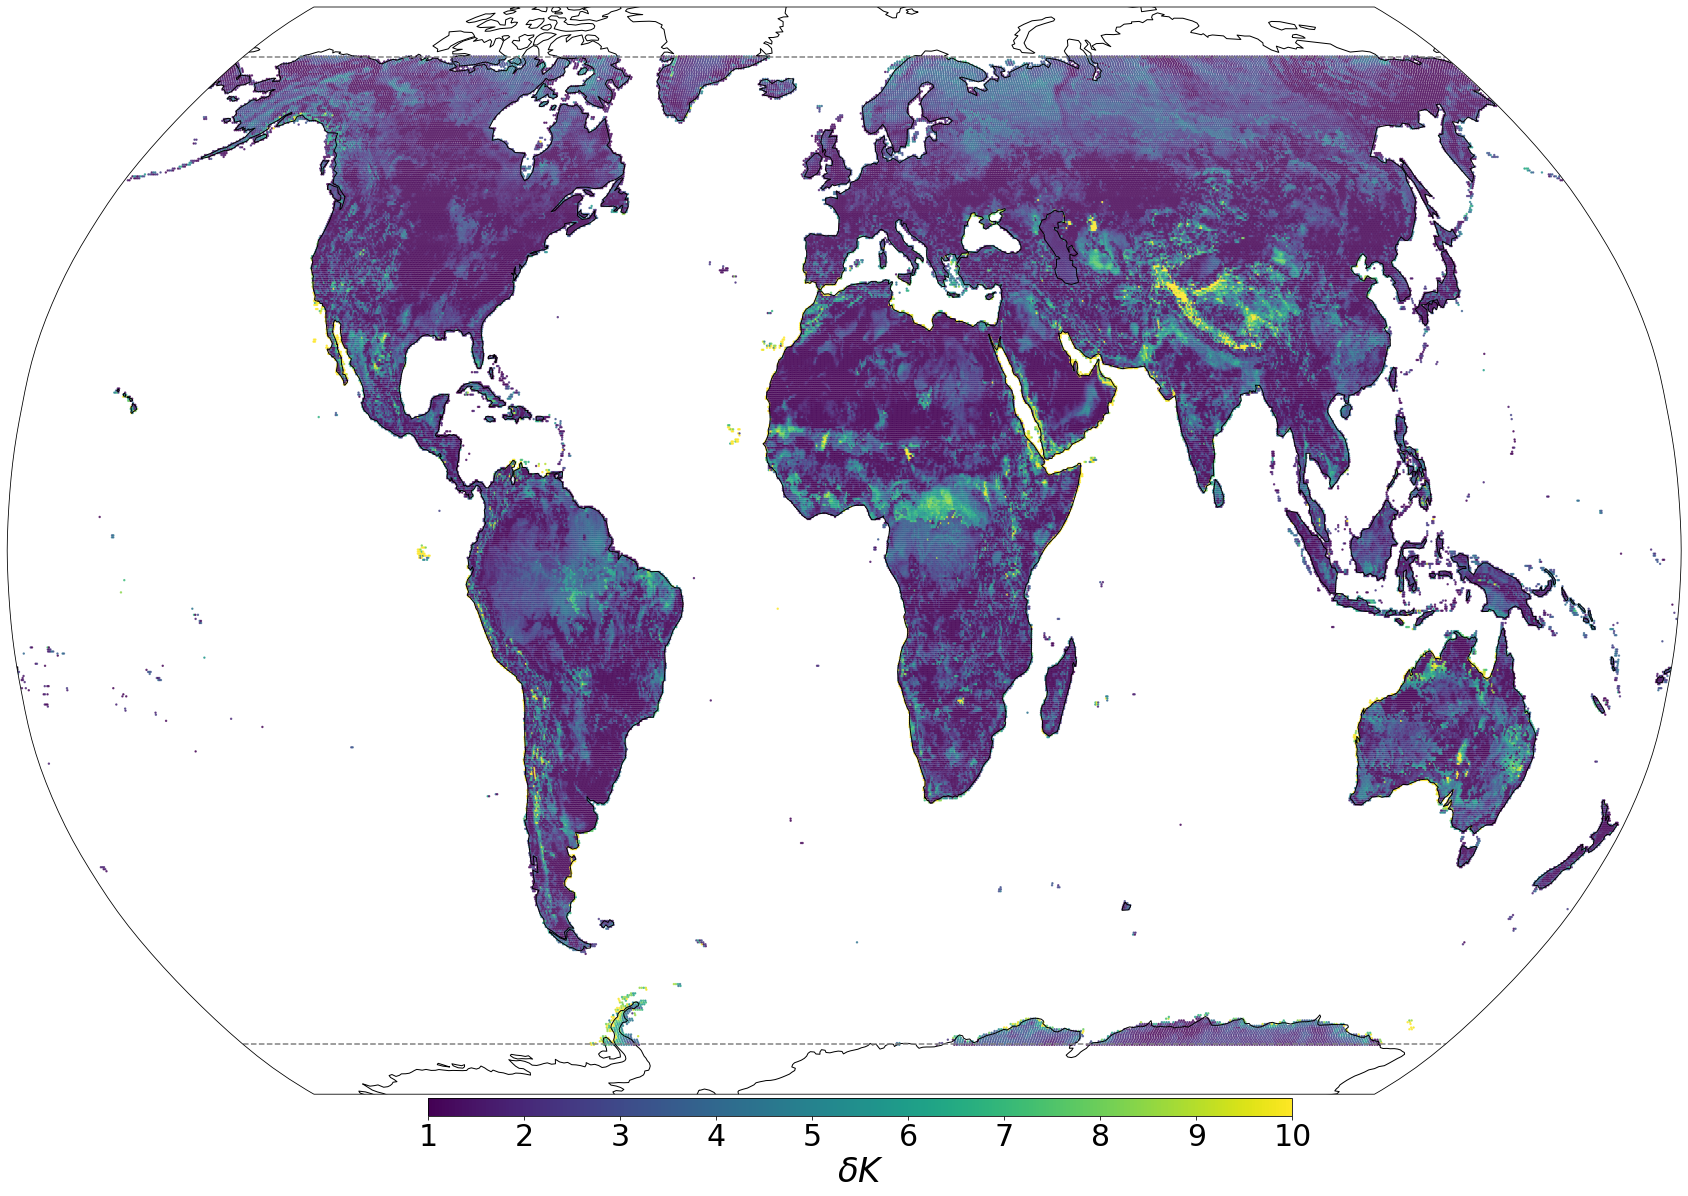

In [11]:
global_plot(yearly_averaged_predictions,
            'ERA_predicion_bias',
            projection=ccrs.Robinson(), #ccrs.PlateCarree() , ccrs.Robinson()
            vmin=1,vmax=10,
            cmap=plt.cm.viridis,
            absolute_values = True,
            logscale=False,
            title=None,
            markersize=2,
            savefig=None,
            cbar_label=r'$\delta K$')

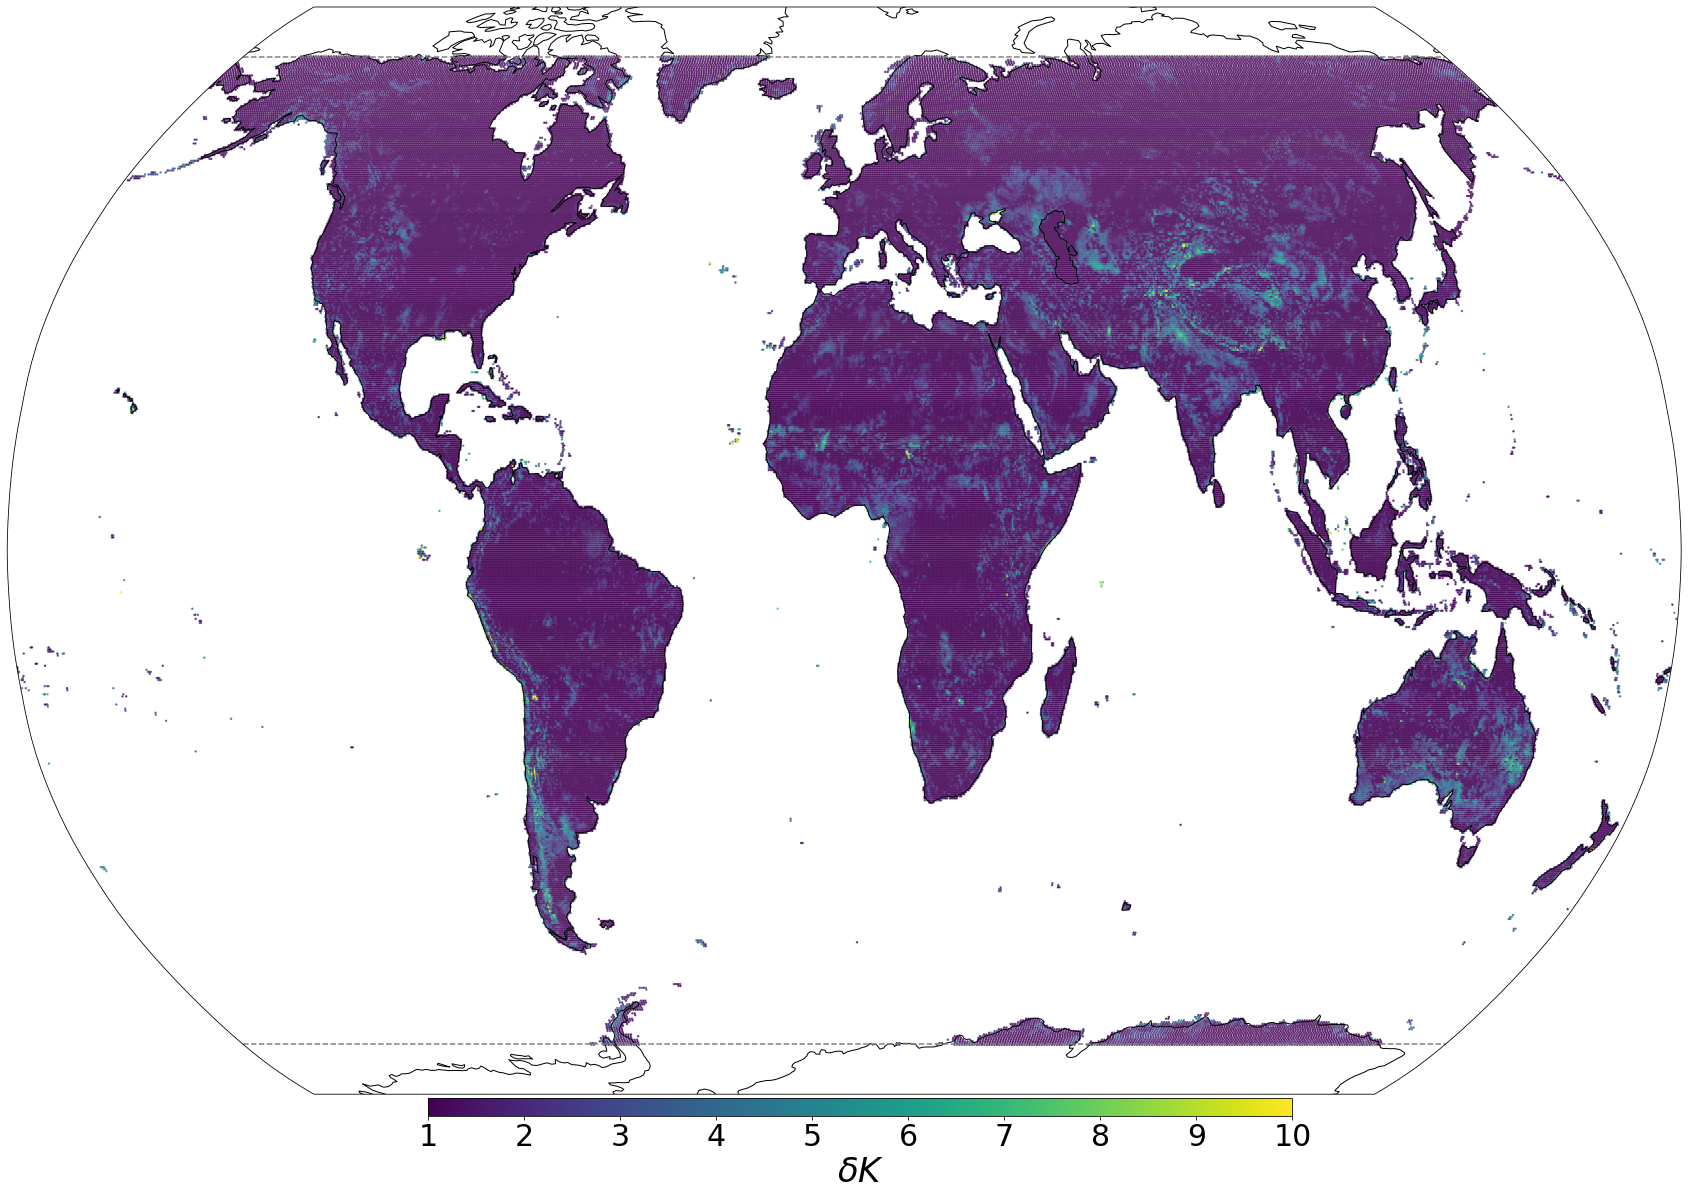

In [12]:

global_plot(yearly_averaged_predictions,
            'model_predicion_bias',
            projection=ccrs.Robinson(), #ccrs.PlateCarree() , ccrs.Robinson()
            vmin=1,vmax=10,
            cmap=plt.cm.viridis,
            absolute_values = True,
            logscale=False,
            title=None,
            markersize=2,
            savefig=None,
            cbar_label=r'$\delta K$')

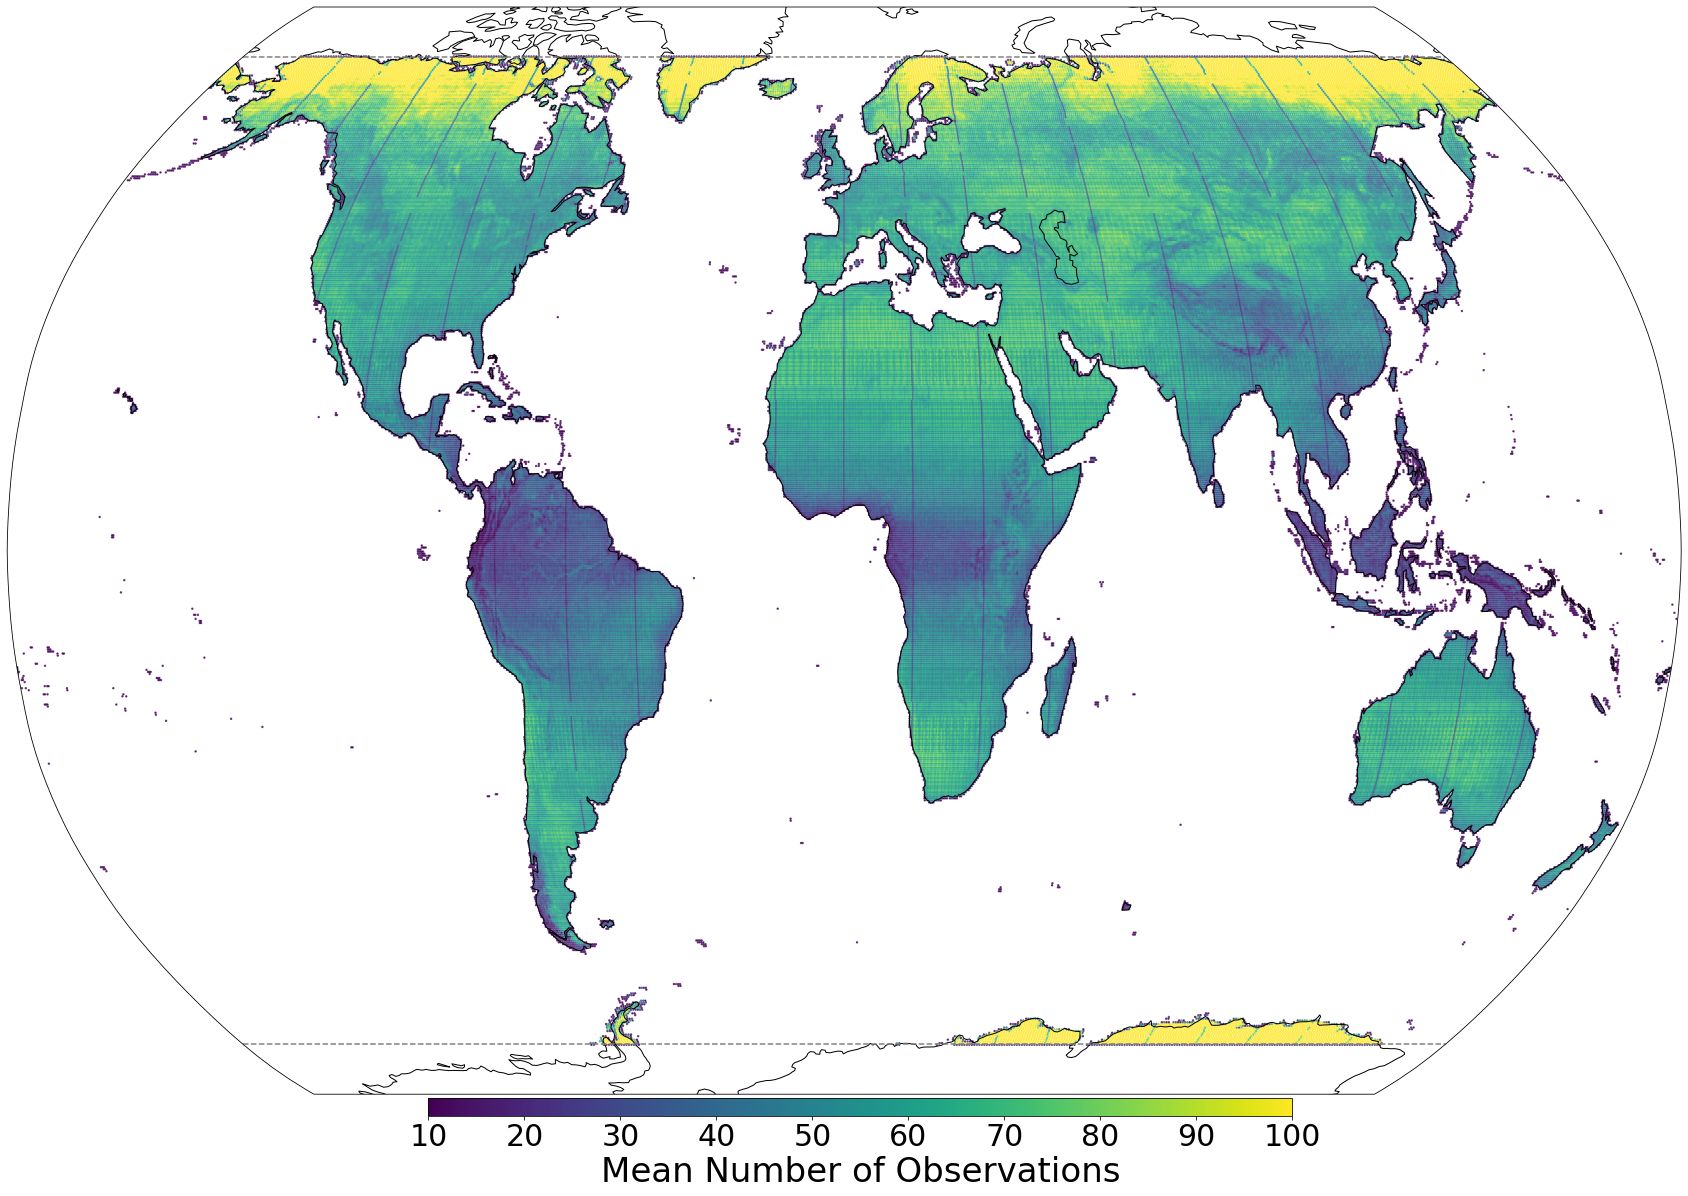

In [13]:
global_plot(yearly_averaged_predictions,
            'number_of_modis_observations',
            projection=ccrs.Robinson(), #ccrs.PlateCarree() , ccrs.Robinson()
            vmin=10,vmax=100,
            cmap=plt.cm.viridis,
            absolute_values = True,
            logscale=False,
            title=None,
            markersize=2,
            savefig='figs/num_obs_map.png',
            cbar_label='Mean Number of Observations')



# Histogram of errors

    


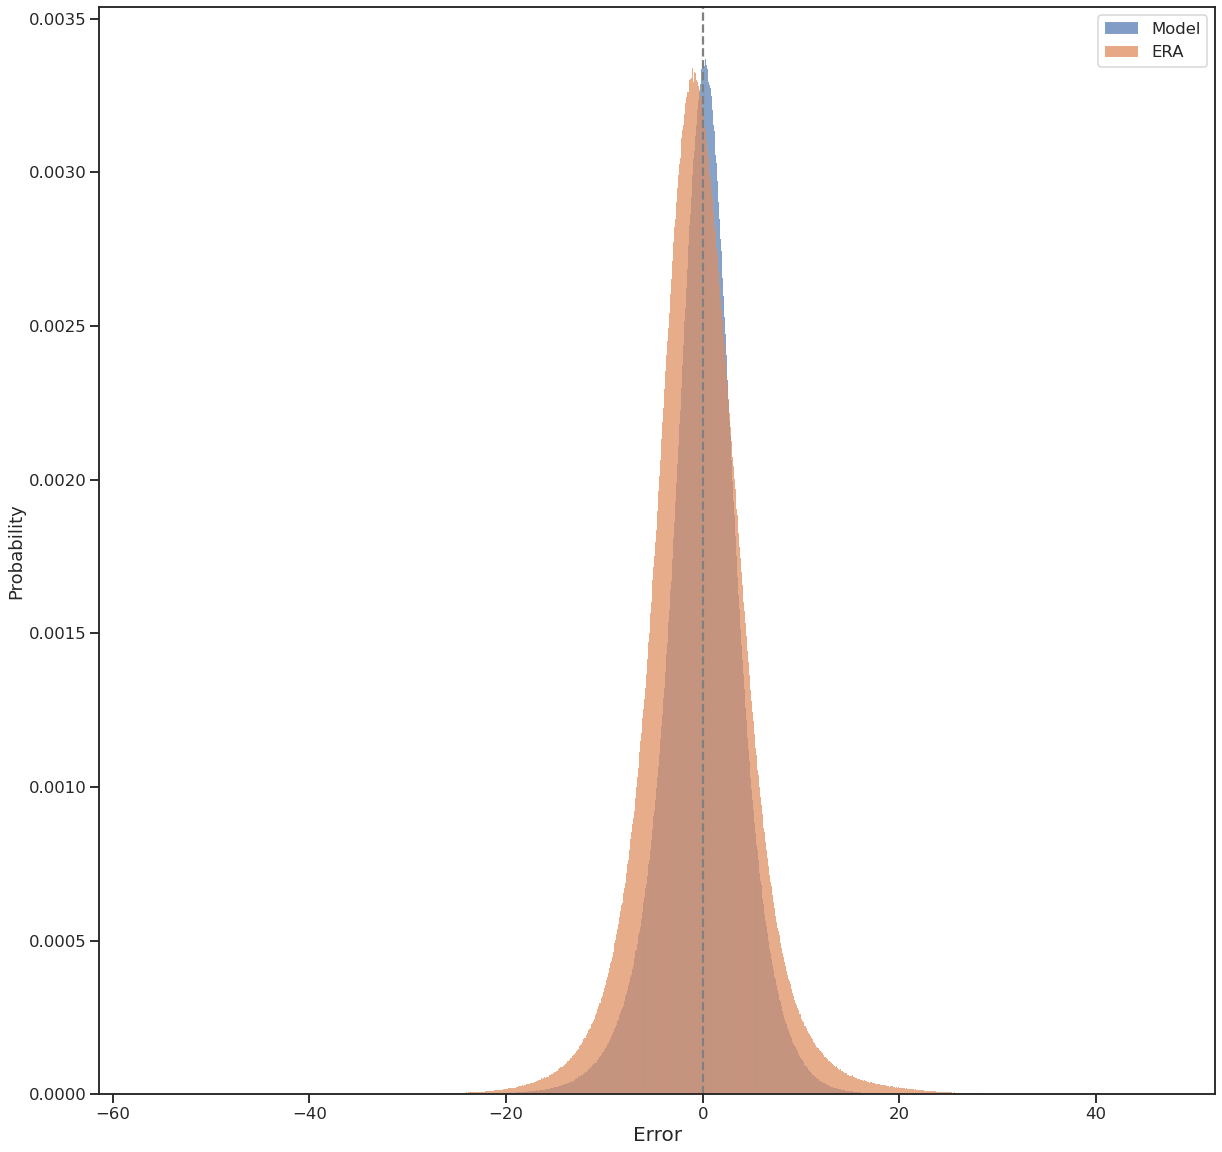

CPU times: user 2min 2s, sys: 3.86 s, total: 2min 6s
Wall time: 2min 10s


In [14]:
%%time


import seaborn as sns
#Plot distribution of errors
#This is quite slow, ~1-2 mins

#Setup plot env
h,w = 20,20

sns.set_theme(context='talk', 
              style='ticks', 
              palette='deep',
              rc={'figure.figsize':(h,w)}
              )


#Figure
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(h,w))






sns.histplot(predictions['model_predicion_bias'], bins='auto', ax=ax1,stat='probability',kde=False,alpha=0.7,color='C0',label='Model')
sns.histplot(predictions['ERA_predicion_bias'], bins='auto', ax=ax1,stat='probability',kde=False,alpha=0.7,color='C1',label='ERA')

# Config
ax1.set_xlabel('Error', fontsize = 20)
ax1.legend().set_title(None)
ax1.axvline(0,c='0.5', linestyle='--')




plt.show()


---


# Appendix

Number of epochs: 229
Minimum training loss: 16.126598358154297
Minimum validation loss: 16.012075424194336


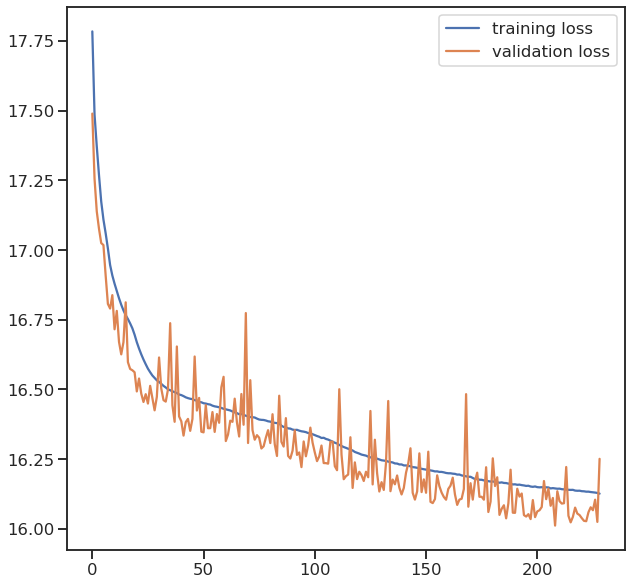

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import json
with open(path_to_model+'training_history.json') as f:
    d = json.load(f)

    training_loss = d['loss'][1:]
    validation_loss = d['val_loss'][1:]
    epochs = np.arange(len(training_loss))
    print ('Number of epochs:', len(epochs))
    print ('Minimum training loss:', min(training_loss))
    print('Minimum validation loss:', min(validation_loss))

    fig = plt.figure(figsize=(10, 10))
    plt.plot(epochs,training_loss,label='training loss')
    plt.plot(epochs,validation_loss, label='validation loss')
    plt.legend()
        


In [16]:
import json
with open(path_to_model+'configuration.json') as f:
    config=json.load(f)
    display(config['train'])

{'training_data': '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/joined_data/2016_MLS.parquet',
 'validation_data': '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/joined_data/2017_MLS.parquet',
 'training_features': ['sp',
  'msl',
  'u10',
  'v10',
  't2m',
  'aluvp',
  'aluvd',
  'alnip',
  'alnid',
  'istl1',
  'istl2',
  'sd',
  'd2m',
  'fal',
  'skt',
  'slt_v15',
  'sdfor_v15',
  'sdor_v15',
  'cvl_v15',
  'lsm_v15',
  'isor_v15',
  'tvl_v15',
  'tvh_v15',
  'cvh_v15',
  'si10_v15',
  'anor_v15',
  'cl_v15',
  'dl_v15',
  'z_v15',
  'slor_v15',
  'clake_monthly_value',
  'cl_saline'],
 'batch_size': 1024,
 'epochs': 300,
 'number_of_hidden_layers': 4,
 'nodes_per_layer': [None, None, None, None],
 'target_variable': 'MODIS_LST',
 'learning_rate': 0.0003,
 'loss': 'mse',
 'metrics': ['accuracy'],
 'path_to_trained_models': '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/proc